In [ ]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import isbnlib
from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import goodreads_api_client as gr
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('C:/Users/ompra/Desktop/books.csv', error_bad_lines = False)



In [60]:
df.index = df['bookID']

In [61]:
#Finding Number of rows and columns
print("Dataset contains {} rows and {} columns".format(df.shape[0], df.shape[1]))


Dataset contains 11123 rows and 12 columns


In [62]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [63]:
df.replace(to_replace='J.K. Rowling-Mary GrandPré', value = 'J.K. Rowling', inplace=True)



In [64]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


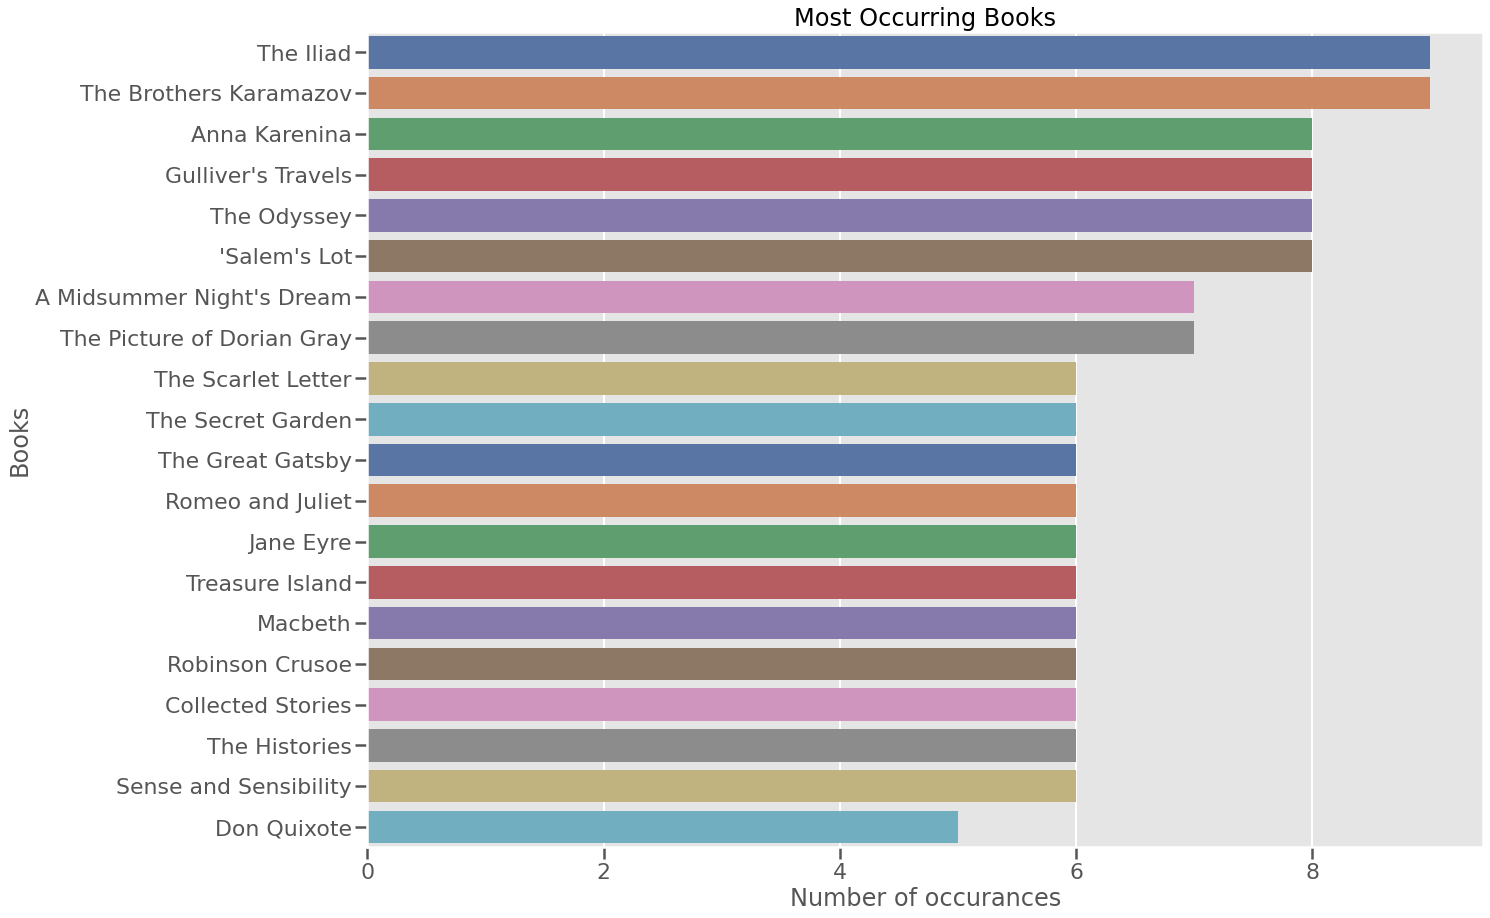

In [65]:
#Taking the first 20:

sns.set_context('poster')
plt.figure(figsize=(20,15))
books = df['title'].value_counts()[:20]
rating = df.average_rating[:20]
sns.barplot(x = books, y = books.index, palette='deep')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

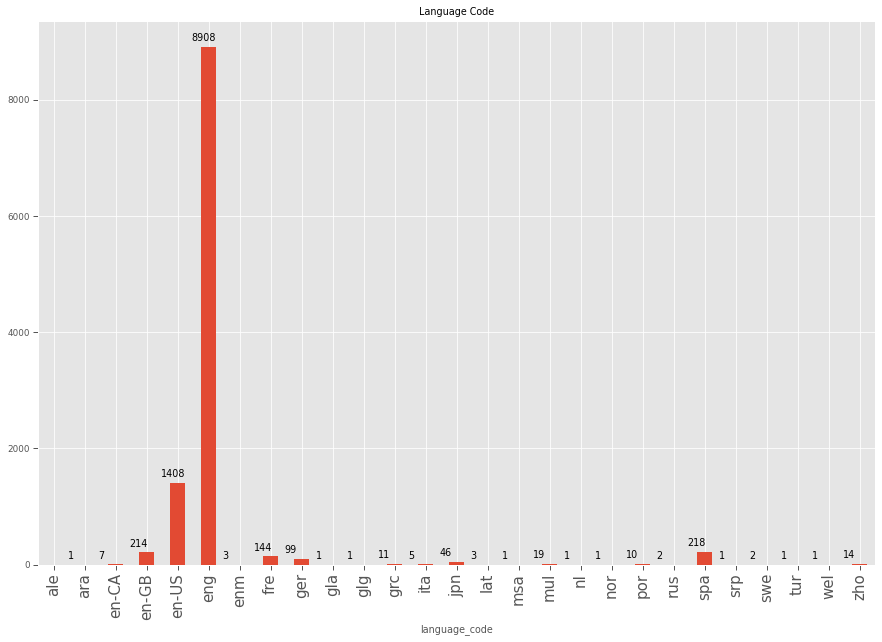

In [66]:
sns.set_context('paper')
plt.figure(figsize=(15,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Code')
plt.xticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.3, p.get_height()+100))

<AxesSubplot:xlabel='ratings_count', ylabel='title'>

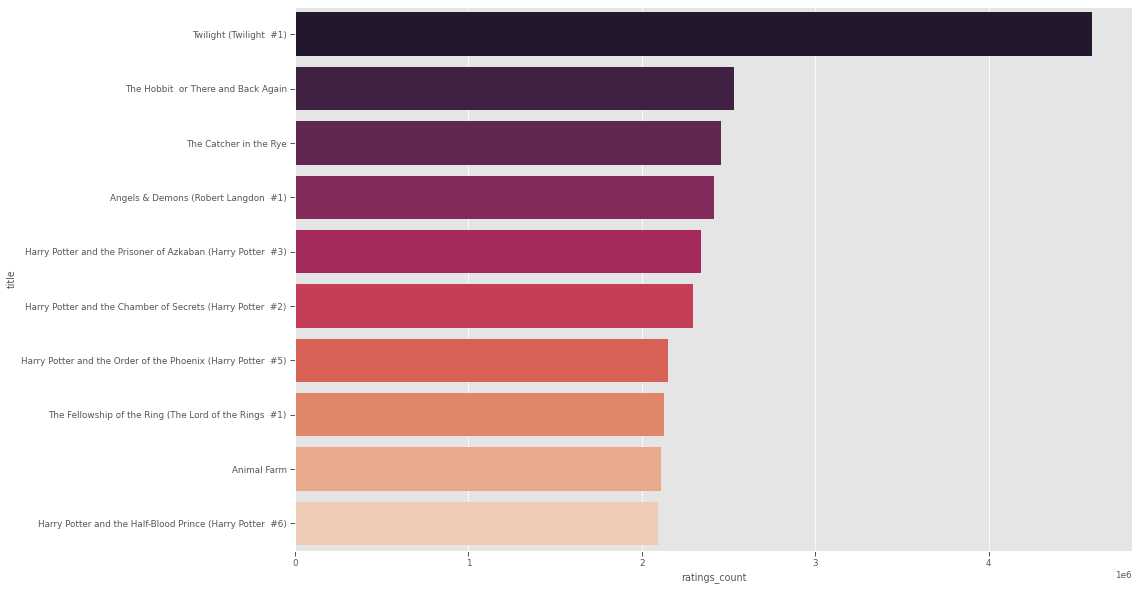

In [67]:
most_rated = df.sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(most_rated['ratings_count'], most_rated.index, palette='rocket')




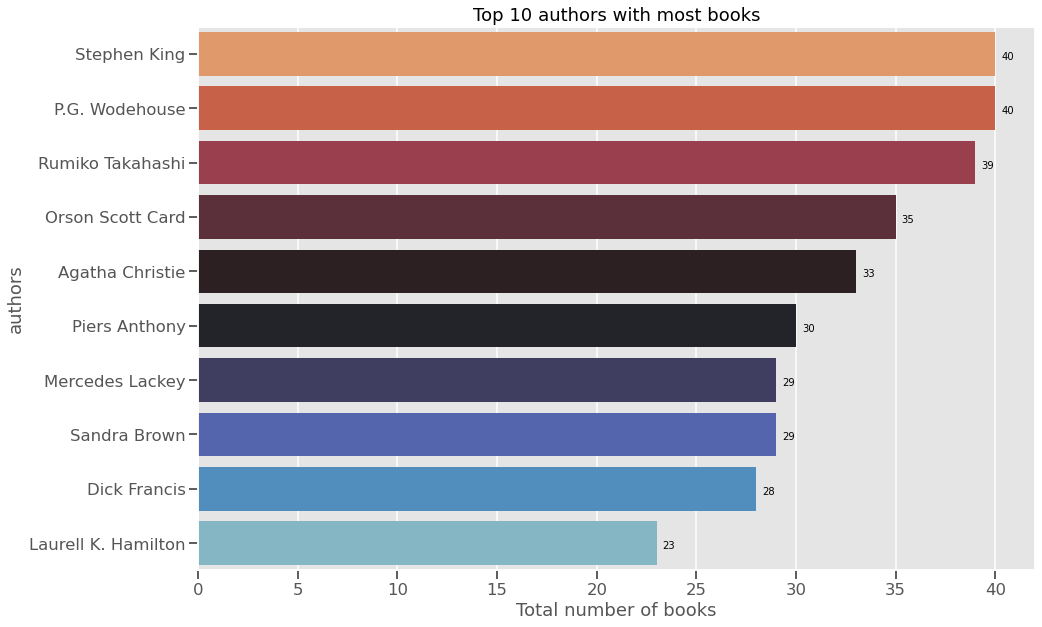

In [68]:
sns.set_context('talk')
most_books = df.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(most_books['title'], most_books.index, palette='icefire_r')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')



In [69]:
client = gr.Client(developer_key= 'fgwnppR6Q1wpFt0n6umUQ')

In [70]:
# Creating a function to get book details from the ISBN 13 value.

#Alternate scraping solution, when both the API(s) fails
def html(isbn):
    url = 'https://isbndb.com/book/'+isbn
    article = Article(url)
    #article = 'https://isbndb.com/book/9780450524684'
    article.download()
    article.parse()
    ar = article.html
    ar = ar[9300:9900]
    return ar

def reg(l):
    return re.search(r'(\b\d{4})\b',l).groups()[0]
    
#Gathering the data for the year column for the books from their ISBN 13 values
def bookdata(df):
    year=[]
    pbar = ProgressBar()
    for isbn in pbar(df.isbn13):
        try:
            details = isbnlib.meta(isbn)
            year.append(details['Year'])
        except :
            #Trying out with goodreads api now
            try: 
                book_detail = client.Book.show_by_isbn(isbn)
                keys_wanted = ['publication_year']
                reduced_book = {k:v for k,v in book_detail.items() if k in keys_wanted}
                year.append((reduced_book['publication_year']))
            
            except: 
                #Going with webscraping
                try:
                    y = html(isbn)
                    year_extracted = reg(y) #Extracting year with regex
                    year.append(y)
                except:
                    year.append('0')
                
    return year

def plot_author_chart(author_df):
    year = bookdata(author_df)
    author_df = final_df(author_df, year)
    author_df.dropna(0, inplace=True)
    author_df = author_df[author_df['Year'].str.isnumeric()]
    author_df = author_df.set_index('title')
    author_df = author_df[author_df.Year !='0']
    plt.figure(figsize=(15,15))
    sns.set_context('talk')
    plt.xticks(rotation=30)
    ax =  sns.barplot( author_df['Year'], author_df['average_rating'], palette='deep')
    ax.set_title("Average rating of books over time, "+ author_df.authors[1])
    plt.xticks(rotation=30)
    return ax



# The finction for getting the final dataframe for the charts
def final_df(df1, l):
    year_df = pd.DataFrame(l, columns=['Year'])
    df1 = df1.reset_index(drop=True)
    final = df1[['authors', 'average_rating', 'title']].join(year_df)
    return final

In [71]:
#Finding the top 15 authors with the most number of books
df['authors'].value_counts().head(10)

Stephen King           40
P.G. Wodehouse         40
Rumiko Takahashi       39
Orson Scott Card       35
Agatha Christie        33
Piers Anthony          30
Sandra Brown           29
Mercedes Lackey        29
Dick Francis           28
Laurell K. Hamilton    23
Name: authors, dtype: int64

In [72]:
authors= ['Stephen King', 'Agatha Christie', 'Dan Brown', 'J.K. Rowling']

100% |########################################################################|


ValueError: min() arg is an empty sequence

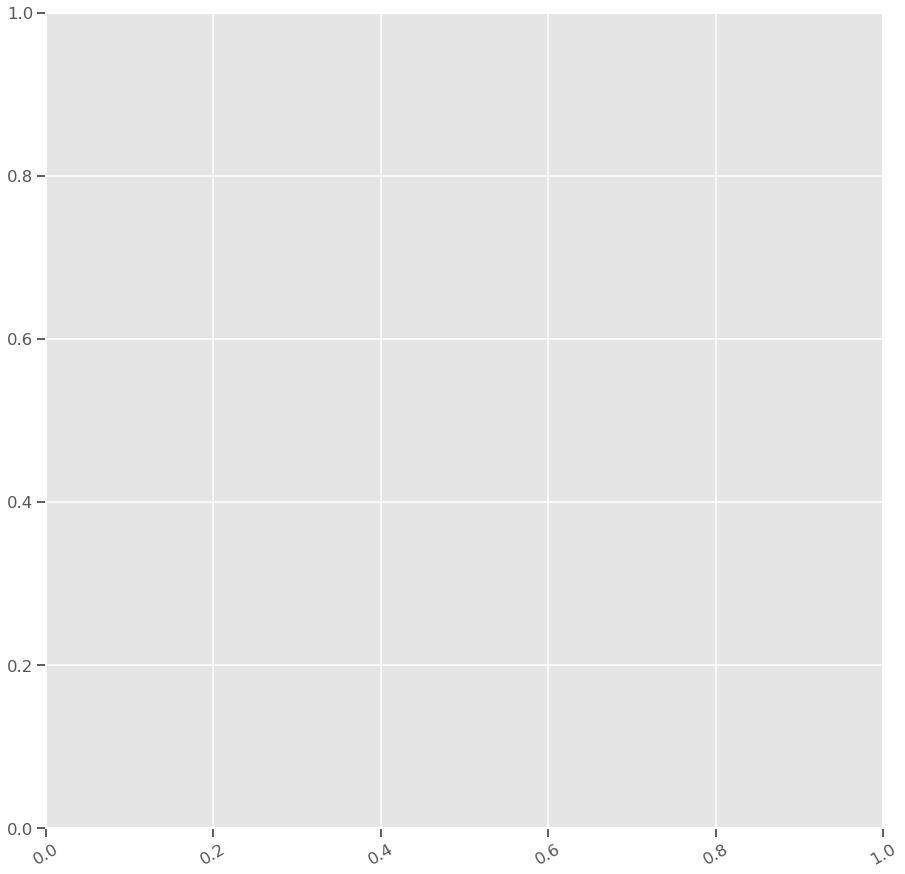

In [74]:
author_df = df[df['authors']==authors[0]]
author_df = author_df[author_df['language_code']=='eng']
plot_author_chart(author_df)

100% |########################################################################|


ValueError: min() arg is an empty sequence

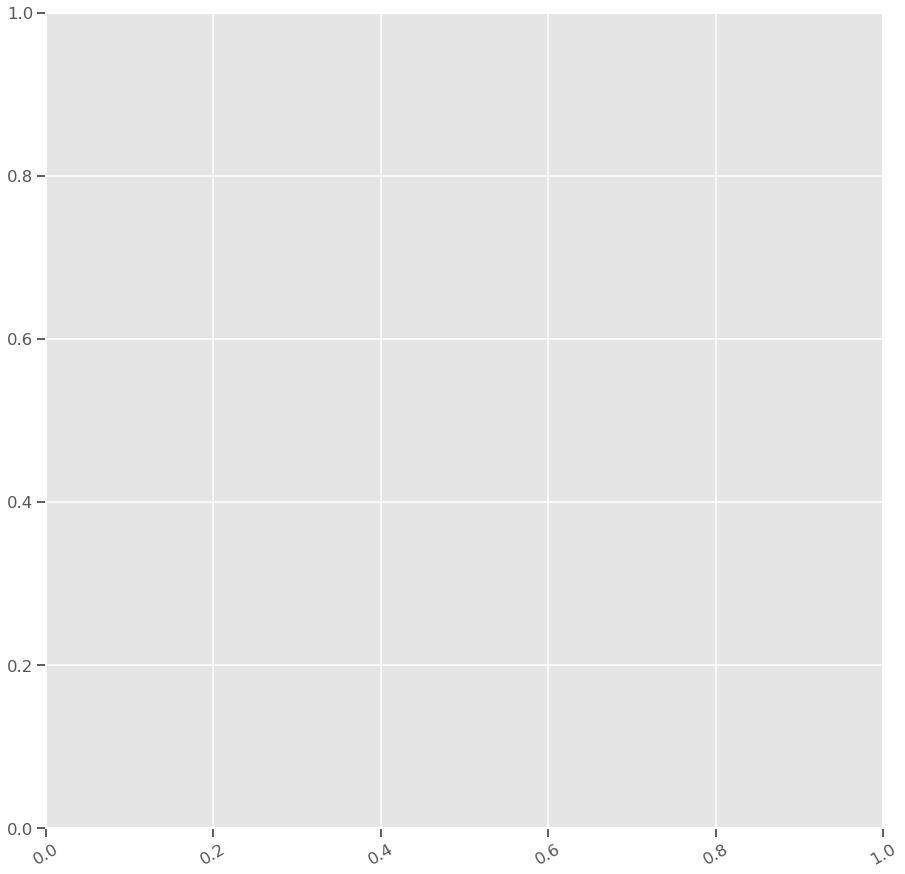

In [75]:
author_df = df[df['authors']==authors[1]]
author_df = author_df[author_df['language_code']=='eng']
plot_author_chart(author_df)

In [ ]:
author_df = df[df['authors']==authors[2]]
author_df = author_df[author_df['language_code']=='eng']
plot_author_chart(author_df)

In [ ]:
author_df = df[df['authors']==authors[3]]
author_df = author_df[author_df['language_code']=='eng']
plot_author_chart(author_df)




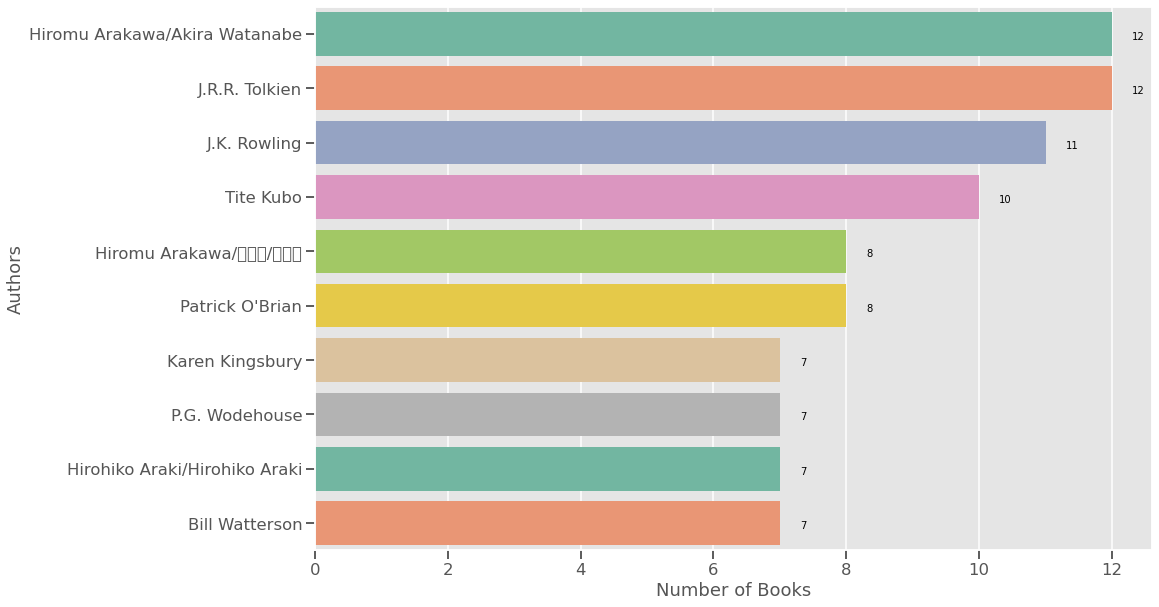

In [76]:
high_rated_author = df[df['average_rating']>=4.3]
high_rated_author = high_rated_author.groupby('authors')['title'].count().reset_index().sort_values('title', ascending = False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(high_rated_author['title'], high_rated_author.index, palette='Set2')
ax.set_xlabel("Number of Books")
ax.set_ylabel("Authors")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')





In [77]:

def segregation(data):
    values = []
    for val in data.average_rating:
        if val>=0 and val<=1:
            values.append("Between 0 and 1")
        elif val>1 and val<=2:
            values.append("Between 1 and 2")
        elif val>2 and val<=3:
            values.append("Between 2 and 3")
        elif val>3 and val<=4:
            values.append("Between 3 and 4")
        elif val>4 and val<=5:
            values.append("Between 4 and 5")
        else:
            values.append("NaN")
    print(len(values))
    return values

In [78]:
df.average_rating.isnull().value_counts()

False    11123
Name: average_rating, dtype: int64

In [79]:
df.dropna(0, inplace=True)
#Removing Any null values

<AxesSubplot:xlabel='average_rating', ylabel='Density'>

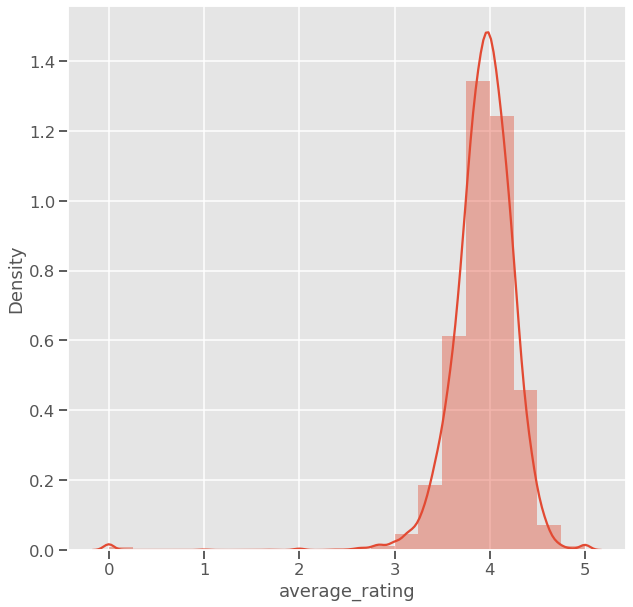

In [80]:
plt.figure(figsize=(10,10))
rating= df.average_rating.astype(float)
sns.distplot(rating, bins=20)



11123


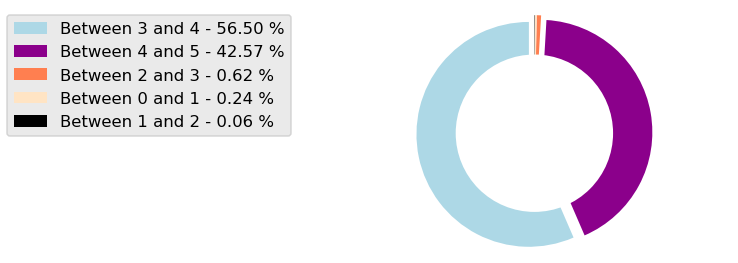

In [81]:
df['Ratings_Dist'] = segregation(df)
ratings_pie = df['Ratings_Dist'].value_counts().reset_index()
labels = ratings_pie['index']
colors = ['lightblue','darkmagenta','coral','bisque', 'black']
percent = 100.*ratings_pie['Ratings_Dist']/ratings_pie['Ratings_Dist'].sum()
fig, ax1 = plt.subplots()
ax1.pie(ratings_pie['Ratings_Dist'],colors = colors, 
        pctdistance=0.85, startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
#Draw a circle now:
centre_circle = plt.Circle((0,0), 0.70, fc ='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
#Equal Aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.legend( labels, loc = 'best',bbox_to_anchor=(-0.1, 1.),)



<Figure size 1080x720 with 0 Axes>

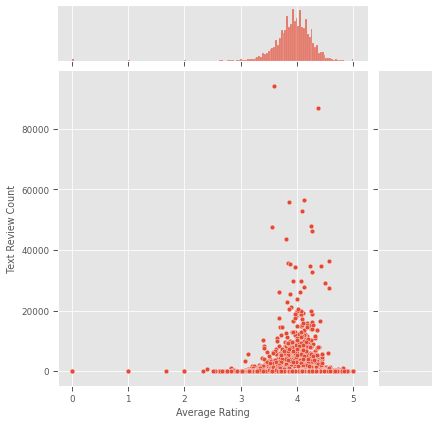

In [82]:
#Checking for any relation between them.
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= df[['text_reviews_count', 'average_rating']])
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()



In [83]:
trial = df[~(df['text_reviews_count']>5000)]

<Figure size 1080x720 with 0 Axes>

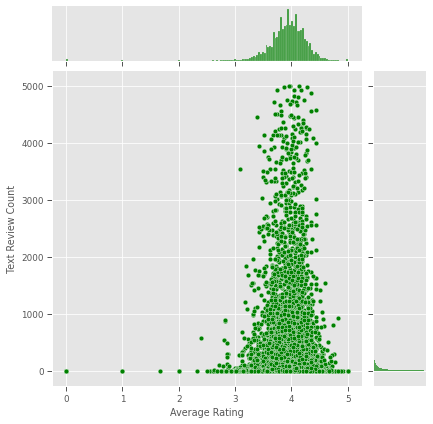

In [84]:
#Checking for any relation between them.
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= trial, color = 'green')
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()



ValueError: Could not interpret value `# num_pages` for parameter `y`

<Figure size 1080x720 with 0 Axes>

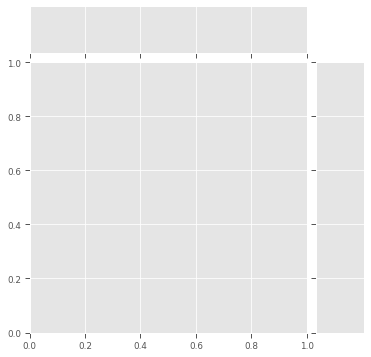

In [85]:
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="# num_pages", data = df, color = 'crimson')
ax.set_axis_labels("Average Rating", "Number of Pages")


In [ ]:
trial = df[~(df['# num_pages']>1000)]

In [ ]:
ax = sns.jointplot(x="average_rating", y="# num_pages", data = trial, color = 'darkcyan')
ax.set_axis_labels("Average Rating", "Number of Pages")


In [ ]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = df, color = 'blueviolet')
ax.set_axis_labels("Average Rating", "Ratings Count")


In [ ]:
trial = df[~(df.ratings_count>2000000)]

In [ ]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = trial, color = 'brown')
ax.set_axis_labels("Average Rating", "Ratings Count")


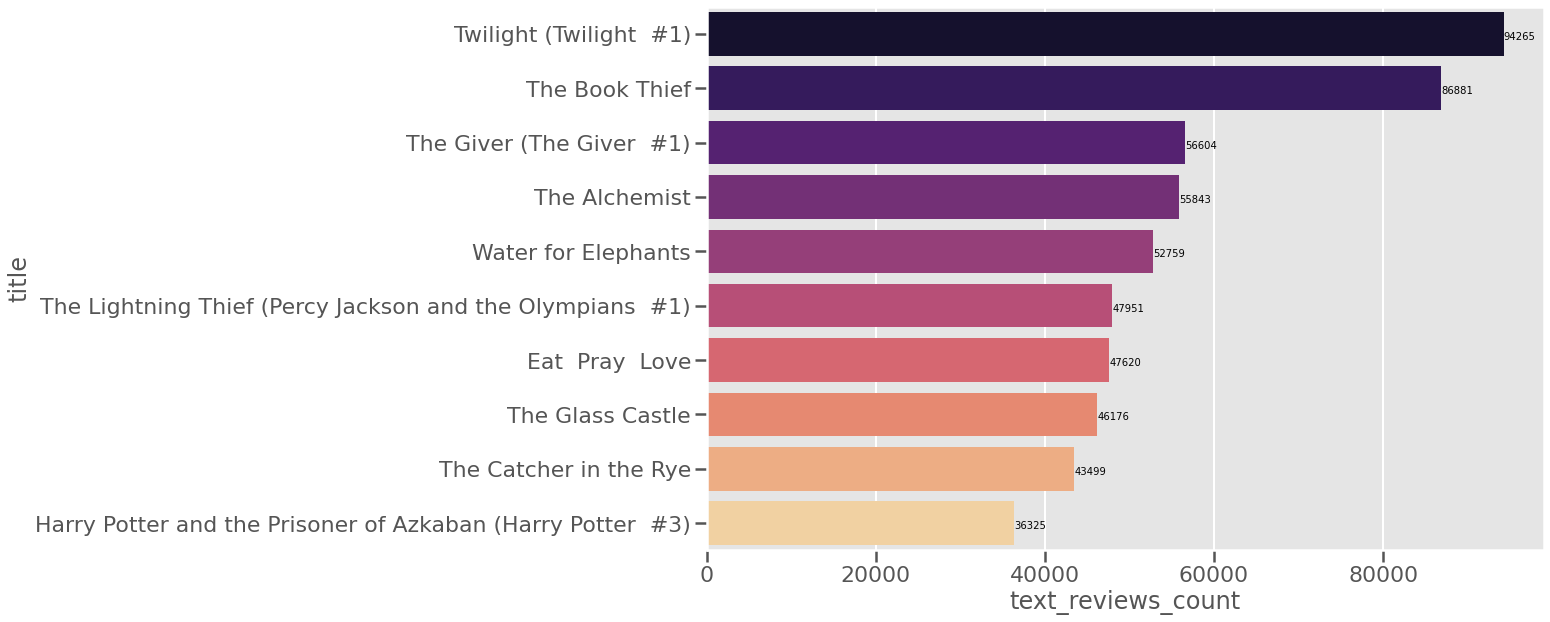

In [86]:
most_text = df.sort_values('text_reviews_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.set_context('poster')
ax = sns.barplot(most_text['text_reviews_count'], most_text.index, palette='magma')
for i in ax.patches:
    ax.text(i.get_width()+2, i.get_y()+0.5,str(round(i.get_width())), fontsize=10,color='black')
plt.show()




In [87]:
trial = df[['average_rating', 'ratings_count']]
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T



Text(0.5, 1.0, 'Elbow Curve')

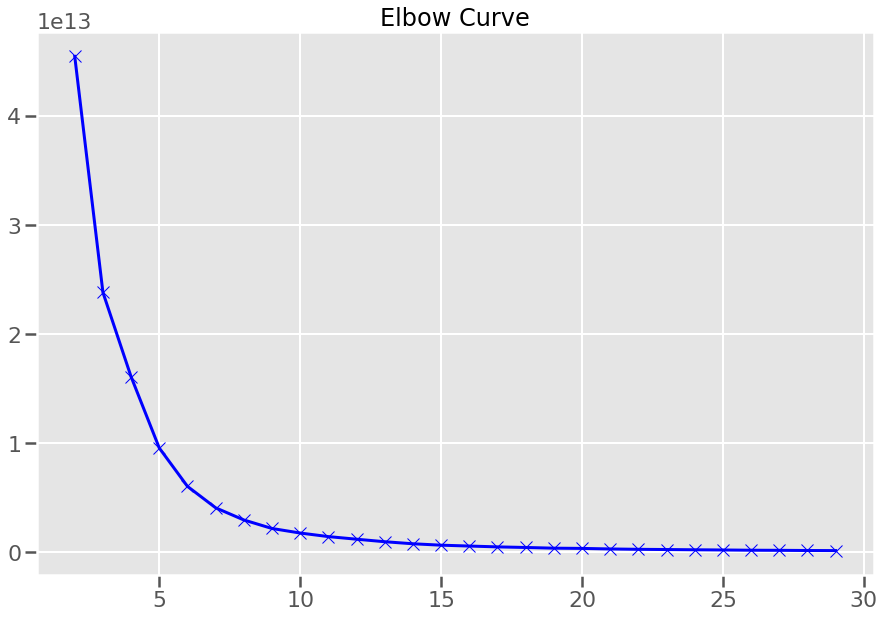

In [88]:
X = data
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

In [89]:
#Computing K means with K = 5, thus, taking it as 5 clusters
centroids, _ = kmeans(data, 5)

#assigning each sample to a cluster
#Vector Quantisation:

idx, _ = vq(data, centroids)

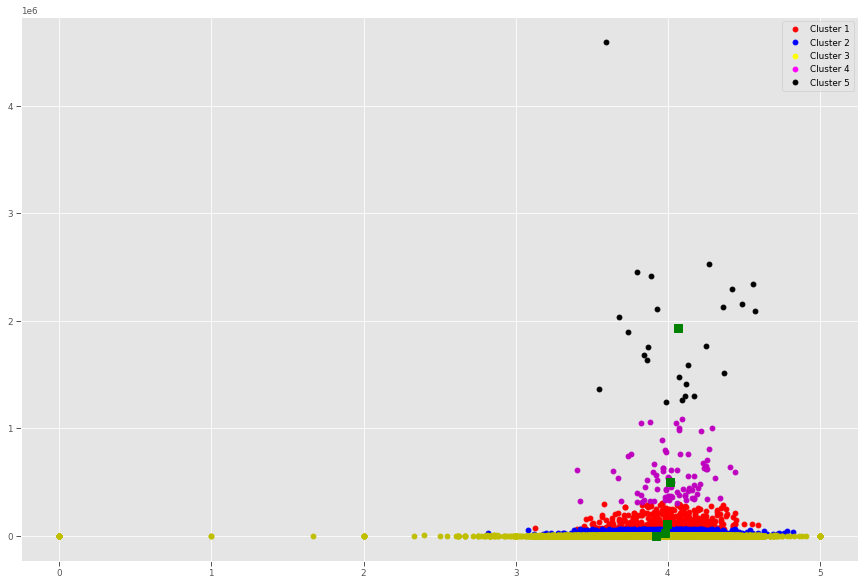

In [90]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(15,10))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles
    
     
        
        
        
        
        )
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )




circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5)
           , ('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), numpoints = 1, loc = 0, )


plt.show()

In [91]:
trial.idxmax()

average_rating     2034
ratings_count     41865
dtype: int64

In [92]:
trial.drop(3, inplace = True)
trial.drop(41865, inplace = True)

KeyError: '[3] not found in axis'

In [93]:
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T




In [94]:
#Computing K means with K = 8, thus, taking it as 8 clusters
centroids, _ = kmeans(data, 5)

#assigning each sample to a cluster
#Vector Quantisation:

idx, _ = vq(data, centroids)

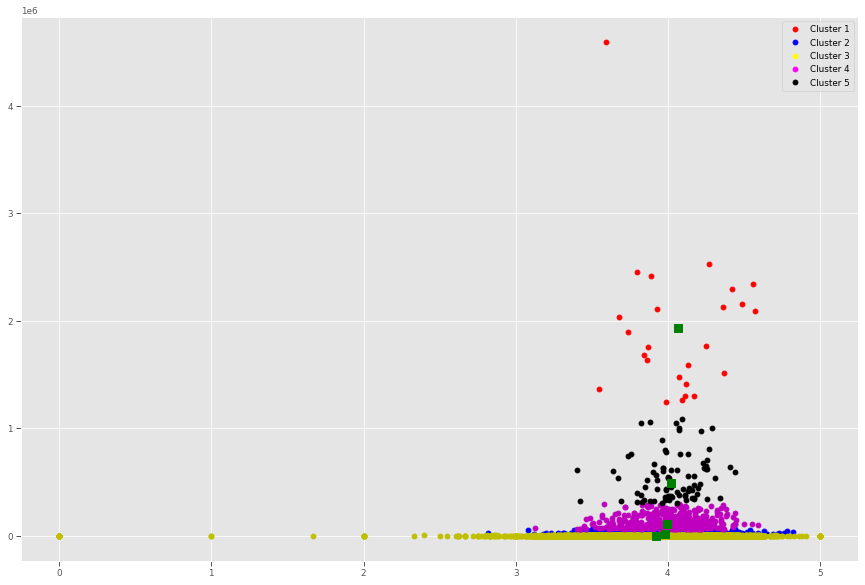

In [95]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(15,10))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles
    
     
        
        
        
        
        )
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )




circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5)
           , ('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), numpoints = 1, loc = 0, )


plt.show()

In [96]:
books_features = pd.concat([df['Ratings_Dist'].str.get_dummies(sep=","), df['average_rating'], df['ratings_count']], axis=1)

In [97]:
books_features.head()

,Between 0 and 1,Between 1 and 2,Between 2 and 3,Between 3 and 4,Between 4 and 5,average_rating,ratings_count
bookID,,,,,,,
1,0,0,0,0,1,4.57,2095690
2,0,0,0,0,1,4.49,2153167
4,0,0,0,0,1,4.42,6333
5,0,0,0,0,1,4.56,2339585
8,0,0,0,0,1,4.78,41428


In [98]:
min_max_scaler = MinMaxScaler()
books_features = min_max_scaler.fit_transform(books_features)

In [99]:
np.round(books_features, 2)

array([[0.  , 0.  , 0.  , ..., 1.  , 0.91, 0.46],
       [0.  , 0.  , 0.  , ..., 1.  , 0.9 , 0.47],
       [0.  , 0.  , 0.  , ..., 1.  , 0.88, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.79, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.74, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.78, 0.  ]])

In [100]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(books_features)
distance, indices = model.kneighbors(books_features)



In [101]:
def get_index_from_name(name):
    return df[df["title"]==name].index.tolist()[0]

all_books_names = list(df.title.values)

def get_id_from_partial_name(partial):
    for name in all_books_names:
        if partial in name:
            print(name,all_books_names.index(name))
            
def print_similar_books(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(df.iloc[id]["title"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(df.iloc[id]["title"])

In [102]:
print_similar_books("The Catcher in the Rye")


Hitchhiker's Guide To The Galaxy: The Filming of the Douglas Adams classic
The Peloponnesian War
Henry and June: From the Unexpurgated Diary of Anaïs Nin
Hemingway & Bailey's Bartending Guide to Great American Writers
Liberty Before Liberalism


In [103]:
print_similar_books("The Hobbit or There and Back Again")

IndexError: list index out of range

In [104]:
get_id_from_partial_name("Harry Potter and the ")

Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Order of the Phoenix (Harry Potter  #5) 1
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 3
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 2
Harry Potter and the Sorcerer's Stone (Harry Potter  #1) 8873
Harry Potter and the Philosopher's Stone (Harry Potter  #1) 10674
Harry Potter and the Goblet of Fire (Harry Potter  #4) 10675


In [105]:
print_similar_books(id = 1) #ID for the Book 5

Harry Potter and the Half-Blood Prince (Harry Potter  #6)
The Fellowship of the Ring (The Lord of the Rings  #1)
Harry Potter and the Chamber of Secrets (Harry Potter  #2)
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
The Hobbit  or There and Back Again
